In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%cd /content/gdrive/My Drive/my_data/

/content/gdrive/My Drive/my_data


In [0]:
from numpy import expand_dims,mean,ones

from numpy.random import randn,randint
from keras.datasets.mnist import load_data
from keras import backend as K
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose
from keras.layers import LeakyReLU,BatchNormalization,Input, Dropout

from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
from functools import partial

In [0]:
from keras.utils import conv_utils
class Conv2DTransposeTest(Conv2DTranspose):
    
    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h,
                                              self.dilation_rate[0])
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w,
                                             self.dilation_rate[1])
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.kernel/(K.epsilon() + K.sum(self.kernel**2)),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

 

Using TensorFlow backend.


In [0]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return K.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}
 
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return K.mean(y_true * y_pred)

In [0]:
# define the standalone critic model
def define_critic(in_shape=(64,64,3)):
  # weight initialization
  init = RandomNormal(stddev=0.001)
  # weight constraint
  const = ClipConstraint(0.001)
  in_layer = Input(shape = in_shape)
  c_layer = in_layer
  # downsample to 14x14
  c_layer = Conv2D(64*3, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(c_layer)
  c_layer = BatchNormalization(momentum=0.999)(c_layer)
  c_layer = LeakyReLU(alpha=0.2)(c_layer)
  c_layer = Dropout(0.25)(c_layer)
	# downsample to 7x7
  c_layer = Conv2D(64*3, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(c_layer)
  c_layer = BatchNormalization(momentum=0.999)(c_layer)
  c_layer = LeakyReLU(alpha=0.2)(c_layer)
  c_layer = Dropout(0.25)(c_layer)
  # downsample to 7x7
  c_layer = Conv2D(64*3, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const)(c_layer)
  c_layer = BatchNormalization(momentum=0.999)(c_layer)
  c_layer = LeakyReLU(alpha=0.2)(c_layer)
  c_layer = Dropout(0.25)(c_layer)
	# scoring, linear activation
  c_layer = Flatten()(c_layer)
  c_layer = Dense(1)(c_layer)
	# compile model
  model = Model(in_layer, c_layer, name = 'define_critic')
  opt = RMSprop(lr=0.00005)
  
  model.compile(loss=wasserstein_loss, optimizer=opt)
  return model

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
  # weight initialization
  init = RandomNormal(stddev=0.001)
  #const = ClipConstraint(0.001)
  # define model
  in_layer = Input(shape = (latent_dim,))
  c_layer = in_layer
  # foundation for 8x8 image
  n_nodes = 128 * 8 * 8 * 3 
  c_layer = Dense(n_nodes, kernel_initializer=init)(c_layer)
  c_layer = LeakyReLU(alpha=0.2)(c_layer)
  c_layer = Reshape((8, 8, 128*3))(c_layer)
  # upsample to 16x16
  c_layer = Conv2DTranspose(128*3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(c_layer)
  c_layer = BatchNormalization(momentum=0.999)(c_layer)
  c_layer = LeakyReLU(alpha=0.2)(c_layer)
  # upsample to 32x32
  c_layer = Conv2DTranspose(128*3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(c_layer)
  c_layer = BatchNormalization(momentum=0.999)(c_layer)
  c_layer = LeakyReLU(alpha=0.2)(c_layer)
    # upsample to 64x64
  c_layer = Conv2DTranspose(128*3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(c_layer)
  c_layer = BatchNormalization(momentum=0.999)(c_layer)
  c_layer = LeakyReLU(alpha=0.2)(c_layer)

  c_layer = Conv2D(3, (8,8), activation='tanh', padding='same', kernel_initializer=init)(c_layer)
  model = Model(in_layer, c_layer, name = 'define_generator')
  return model

In [0]:
import numpy as np
# load images
def load_real_samples():
	# load dataset

  data_frames = np.load('frames_64x64.npy')
	# convert from ints to floats
  data_frames = data_frames.astype('float32')
	# scale from [0,255] to [-1,1]
  data_frames = (data_frames - 127.5) / 127.5
  return data_frames

  # select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

  # generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

In [0]:
from IPython.display import clear_output
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
  clear_output()
	# prepare fake examples
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
	# plot images
  for i in range(10 * 10):
		# define subplot
    pyplot.subplot(10, 10, 1 + i)
		# turn off axis
    pyplot.axis('off')
		# plot raw pixel data
    pyplot.imshow(X[i])
	# save plot to file
  pyplot.show()
	# save the generator model
	
	
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('plot_line_plot_loss2.png')
	pyplot.close()

In [0]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
  # calculate the number of batches per training epoch
  bat_per_epo = int(dataset.shape[0] / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # calculate the size of half a batch of samples
  half_batch = int(n_batch )
  # lists for keeping track of loss
  c1_hist, c2_hist, g_hist = list(), list(), list()
  # manually enumerate epochs
  for i in range(n_steps):
    c1_tmp, c2_tmp = list(), list()
    c_model.trainable = True
    g_model.trainable = False

    for _ in range(n_critic):
			# get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
      c_loss1 = c_model.train_on_batch(X_real, y_real)
      c1_tmp.append(c_loss1)
			# generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
      c_loss2 = c_model.train_on_batch(X_fake, y_fake)
      c2_tmp.append(c_loss2)

    c_model.trainable = False
    g_model.trainable = True
    # store critic loss
    c1_hist.append(mean(c1_tmp))
    c2_hist.append(mean(c2_tmp))
    X_real, y_real = generate_real_samples(dataset, n_batch)
    # prepare points in latent space as input for the generator
    X_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = -ones((n_batch, 1))
    # update the generator via the critic's error
    g_loss = gan_model.train_on_batch([X_gan,X_real], [y_real,y_gan,y_real])
    g_hist.append(g_loss[1])
    # summarize loss on this batch
    print('>%d, c1=%.3f, c2=%.3f g=%.3f pg=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss[1],g_loss[2]))
    # evaluate the model performance every 'epoch'
    if (i+1) % bat_per_epo == 0:
      summarize_performance(i, g_model, latent_dim)
  # line plots of loss
  plot_history(c1_hist, c2_hist, g_hist)
 


In [0]:
def train_new(g_model, c_model, critic_model,generator_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
  sample_interval=50
  valid = -np.ones((n_batch, 1))
  fake =  np.ones((n_batch, 1))
  dummy = np.zeros((n_batch, 1))
  half_batch = int(n_batch )
  for epoch in range(n_epochs):
    for _ in range(n_critic):
      # ---------------------
      #  Train Discriminator
      # ---------------------
      
      imgs, _ = generate_real_samples(dataset, half_batch)
      noise = generate_latent_points(latent_dim, half_batch)
      # Train the critic
      d_loss = critic_model.train_on_batch([imgs, noise],[valid, fake, dummy])

      # ---------------------
      #  Train Generator
      # ---------------------
    noise = generate_latent_points(latent_dim, n_batch)
    g_loss = generator_model.train_on_batch(noise, valid)
    # Plot the progress
    print ("%d [C loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
    # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
      summarize_performance(i, g_model, latent_dim)

 


In [0]:
def gradient_penalty_loss(y_true, y_pred, averaged_samples):
  gradients = K.gradients(y_pred, averaged_samples)[0]
  # compute the euclidean norm by squaring ...
  gradients_sqr = K.square(gradients)
  #   ... summing over the rows ...
  gradients_sqr_sum = K.sum(gradients_sqr,axis=np.arange(1, len(gradients_sqr.shape)))
  #   ... and sqrt
  gradient_l2_norm = K.sqrt(gradients_sqr_sum)
  # compute lambda * (1 - ||grad||)^2 still for each single sample
  gradient_penalty = K.square(1 - gradient_l2_norm)
  # return the mean as loss over all the batch samples
  return K.mean(gradient_penalty)


In [0]:
def _compute_gradients(tensor, var_list):
  grads = K.gradients(tensor, var_list)
  return [grad if grad is not None else K.zeros_like(var) for var, grad in zip(var_list, grads)]
#r1/r2 gradient penalty
def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    gradients = _compute_gradients(y_pred, [averaged_samples])[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    
    return K.mean(gradient_penalty * weight)

In [0]:
from keras.layers.merge import _Merge
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

In [0]:
critic.trainable = False
latent_dim = 300

# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)

real_img = Input(shape=(64,64,3))
z_disc = Input(shape=(latent_dim,))
fake_img = generator(z_disc)

fake = critic(fake_img)
valid = critic(real_img)

interpolated_img = RandomWeightedAverage()([real_img, fake_img])
validity_interpolated = critic(interpolated_img)

partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

critic_model = Model(inputs=[real_img, z_disc], outputs=[valid, fake, validity_interpolated])
opt = RMSprop(lr=0.00001)
critic_model.compile(loss=[wasserstein_loss,
                           wasserstein_loss,
                           partial_gp_loss],
                     optimizer=opt,
                     loss_weights=[1, 1, 10])

critic.trainable = False
generator.trainable = True
z_gen = Input(shape=(latent_dim,))
img = generator(z_gen)
valid = critic(img)
generator_model = Model(z_gen, valid)
generator_model.compile(loss=wasserstein_loss, optimizer=opt)

dataset = load_real_samples()
print(dataset.shape)

# train model
train_new(generator, critic, critic_model,generator_model, dataset, latent_dim,n_epochs=50, n_batch=32, n_critic=5)


(2503, 64, 64, 3)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [C loss: 3.444063] [G loss: 0.028246]


NameError: ignored

In [0]:
pyplot.rcParams['figure.figsize'] = (15,15)
# size of the latent space
latent_dim = 300
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan

critic.trainable = False

in_layer = Input(shape = (latent_dim,))
in_layer_real_image = Input(shape = (64,64,3))
c_layer = in_layer
c_layer_im = generator(c_layer)
c_layer_fake = critic(c_layer_im)
c_layer_real = critic(in_layer_real_image)
opt = RMSprop(lr=0.00001)

partial_gp_loss = partial(gradient_penalty_loss, averaged_samples = c_layer_im, weight = 10)

gan_model = Model([in_layer,in_layer_real_image], [c_layer_real,c_layer_fake,c_layer_real], name = 'define_gan')

gan_model.compile(loss=[wasserstein_loss,wasserstein_loss,partial_gp_loss], optimizer=opt)

# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim,n_epochs=50, n_batch=16, n_critic=5)




(2503, 64, 64, 3)
>1, c1=-5.715, c2=0.002 g=-15.504 pg=-0.004
>2, c1=-19.103, c2=-0.001 g=-21.405 pg=-0.216
>3, c1=-25.551, c2=-0.003 g=-27.565 pg=-1.155
>4, c1=-29.949, c2=-0.006 g=-33.945 pg=-5.118
>5, c1=-34.236, c2=-0.010 g=-37.708 pg=-14.537
>6, c1=-36.909, c2=-0.016 g=-40.026 pg=-22.419
>7, c1=-40.132, c2=-0.025 g=-41.160 pg=-29.655
>8, c1=-42.034, c2=-0.033 g=-45.586 pg=-33.297
>9, c1=-45.808, c2=-0.046 g=-42.985 pg=-35.433
>10, c1=-47.797, c2=-0.063 g=-48.743 pg=-36.791
>11, c1=-48.159, c2=-0.079 g=-52.638 pg=-39.912
>12, c1=-51.856, c2=-0.102 g=-51.629 pg=-43.934
>13, c1=-52.592, c2=-0.127 g=-56.528 pg=-45.871
>14, c1=-56.711, c2=-0.162 g=-55.498 pg=-48.618
>15, c1=-58.197, c2=-0.201 g=-59.420 pg=-49.904


KeyboardInterrupt: ignored

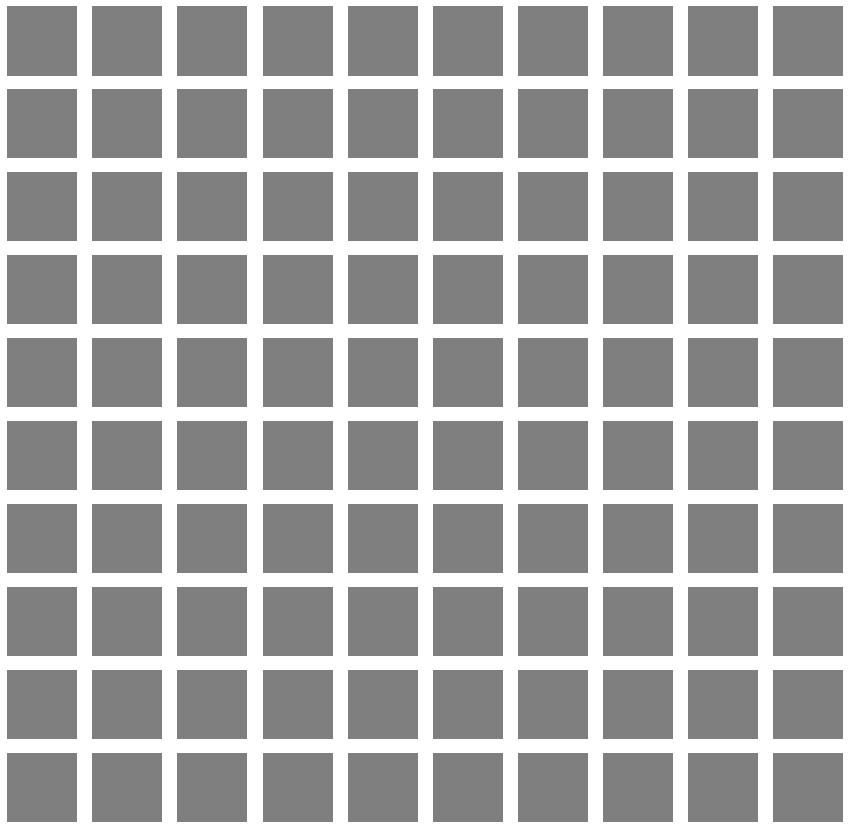

In [0]:
summarize_performance(1, generator, 300)

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

